In [42]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import sys
import os

## For plotting
from matplotlib.colors import LogNorm

WORK_DIR = "/home/isaac/TREE-Sims/Invasive"
SIMOUT_DIR = os.path.join(WORK_DIR, "2d_sims/")

os.chdir(SIMOUT_DIR)

invasion_times = [10000, 100000, 1000000]
invasiveness_levels = [0.05, 0.2, 0.5, 0.75]
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
time_tolerance = 0.01

for itime in invasion_times:
    dirs = glob.glob(str(itime)+"-*")
    for d in dirs:
        iterations = glob.glob(d+"/*")
        print("{} nsims {}".format(d, len(iterations)))

10000-0.75 nsims 957
10000-0.2 nsims 352
10000-0.5 nsims 717
10000-0.05 nsims 148
100000-0.05 nsims 147
100000-0.5 nsims 589
100000-0.75 nsims 720
100000-0.2 nsims 326
1000000-0.5 nsims 211
1000000-0.05 nsims 139
1000000-0.2 nsims 181
1000000-0.75 nsims 219


In [43]:
def fetch_pidxy_simdata(simfiles):
    ## First gather all the data for pi and dxy
    pi_dat = []
    dxy_dat = []
    for f in simfiles:
        lines = open(f).readlines()
        tmp_pi = []
        tmp_dxy = []
        for line in lines:
            try:
                ## Parse each line and get rid of bracket characters
                ldat = line.strip().split()
                l = [float(ldat[0])] + [float(x.translate(None, "[],")) for x in ldat[2:]]
                if "pi" in ldat:
                    tmp_pi.append(l)
                else:
                    tmp_dxy.append(l)
            except Exception as inst:
                print(inst)
        pi_dat.extend(tmp_pi)
        dxy_dat.extend(tmp_dxy)
    print("Processed ntimepoints {} {}".format(len(pi_dat), len(dxy_dat)))
    #print(dxy_dat[:1])

    ## Now go through
    pi_dists = {}
    dxy_dists = {}
    ## Dict for storing distributions per timepoint
    for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
        lambda_dists = {perc:[] for perc in sampling_lambdas}
        ## Ineffecient but i don't care
        for percent in sampling_lambdas:
            tmpdat = []
            for line in dat:
                ## If the difference between the lambda for each line
                ## is close enough to the sampling lambda we want then keep the coltimes
                if abs(line[0] - percent) < time_tolerance:
                    m = np.array(line[2:])
                    p = m[m<0.2]
                    p = p[p>=0]
                    tmpdat.extend(p)
            ## Only sample the first 100000 pi/dxy values
            lambda_dists[percent] = tmpdat[:100000]
        print("Got n datapoints per lambda:")
        for k,v in lambda_dists.items():
            print("{} - {}\t".format(k, len(v))),
        print("\n")
        if "pi" in g:
            pi_dists = lambda_dists
        else:
            dxy_dists = lambda_dists
    return {"pi":pi_dists, "dxy":dxy_dists}

In [44]:
## Fetch all data per invasion time and invasiveness level
## Populate a dict of dicts of dicts
##
## There are many species per timepoint, so there will be many more pi/dxy values in the dict than
## there are timepoints.
pi_dxy_dat = {}
for i in invasion_times:
    pi_dxy_dat[i] = {}
    for j in invasiveness_levels:
        pi_dxy_dat[i][j] = {}

for i in invasion_times:
    for j in invasiveness_levels:
        ## Get the files
        print("Doing {} {}".format(i, j))
        simfiles = glob.glob(str(i) + "-" + str(j) + "/*/pidxy.txt")
        pi_dxy_dat[i][j] = fetch_pidxy_simdata(simfiles)

Doing 10000 0.05
Processed ntimepoints 8966 8966
Got n datapoints per lambda:
0.25 - 32378	0.5 - 51492	0.05 - 18878	0.1 - 14719	1 - 100000	0.75 - 53447	Got n datapoints per lambda:
0.25 - 32378	0.5 - 51492	0.05 - 18878	0.1 - 14719	1 - 100000	0.75 - 53447	Doing 10000 0.2
Processed ntimepoints 13901 13901
Got n datapoints per lambda:
0.25 - 74228	0.5 - 100000	0.05 - 40812	0.1 - 39031	1 - 100000	0.75 - 52692	Got n datapoints per lambda:
0.25 - 74228	0.5 - 100000	0.05 - 40812	0.1 - 39031	1 - 100000	0.75 - 52692	Doing 10000 0.5
Processed ntimepoints 14550 14550
Got n datapoints per lambda:
0.25 - 100000	0.5 - 53513	0.05 - 84051	0.1 - 78131	1 - 100000	0.75 - 26874	Got n datapoints per lambda:
0.25 - 100000	0.5 - 53513	0.05 - 84051	0.1 - 78131	1 - 100000	0.75 - 26874	Doing 10000 0.75
Processed ntimepoints 13746 13746
Got n datapoints per lambda:
0.25 - 91969	0.5 - 40630	0.05 - 100000	0.1 - 100000	1 - 100000	0.75 - 18604	Got n datapoints per lambda:
0.25 - 91969	0.5 - 40630	0.05 - 100000	0.1 -

In [22]:
## Does what we got make sense?
print(len(pi_dxy_dat[100000][0.75]["pi"][0.5]))

100000


In [36]:
## Define the function to make the plots. The function takes pi and dxy data per lambda as a dict
def plot_2dSGD_per_lambda(pi_dat, dxy_dat, inv_time, inv_level):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True, sharey=True)
    axarr = [a for b in axarr for a in b]
    cmap="jet"
    ## Set min and max range for pi and dxy respectively
    rang=[[0.001, 0.02], [0, 0.06]]
    for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k), fontsize=10)
        _, _, _, im = ax.hist2d(pi_dat[k], dxy_dat[k], bins=30, cmap=cmap, norm=LogNorm(), normed=True, range=rang)
    f.text(0.5, 0.01, u"Nucleotide diversity (π)", ha='center', fontsize=13)
    f.text(0.04, 0.5, r"Absolute divergence ($D_{xy}$)", va='center', rotation='vertical', fontsize=13)
    plt.suptitle("2D-SGD Through Time for Invasion {} and Invasiveness {}".format(inv_time, inv_level), y=.9999, fontsize=15)
    plt.subplots_adjust(hspace=.25)

    cb_ax = f.add_axes([0.93, 0.12, 0.015, 0.76])
    cbar = f.colorbar(im, cax=cb_ax)


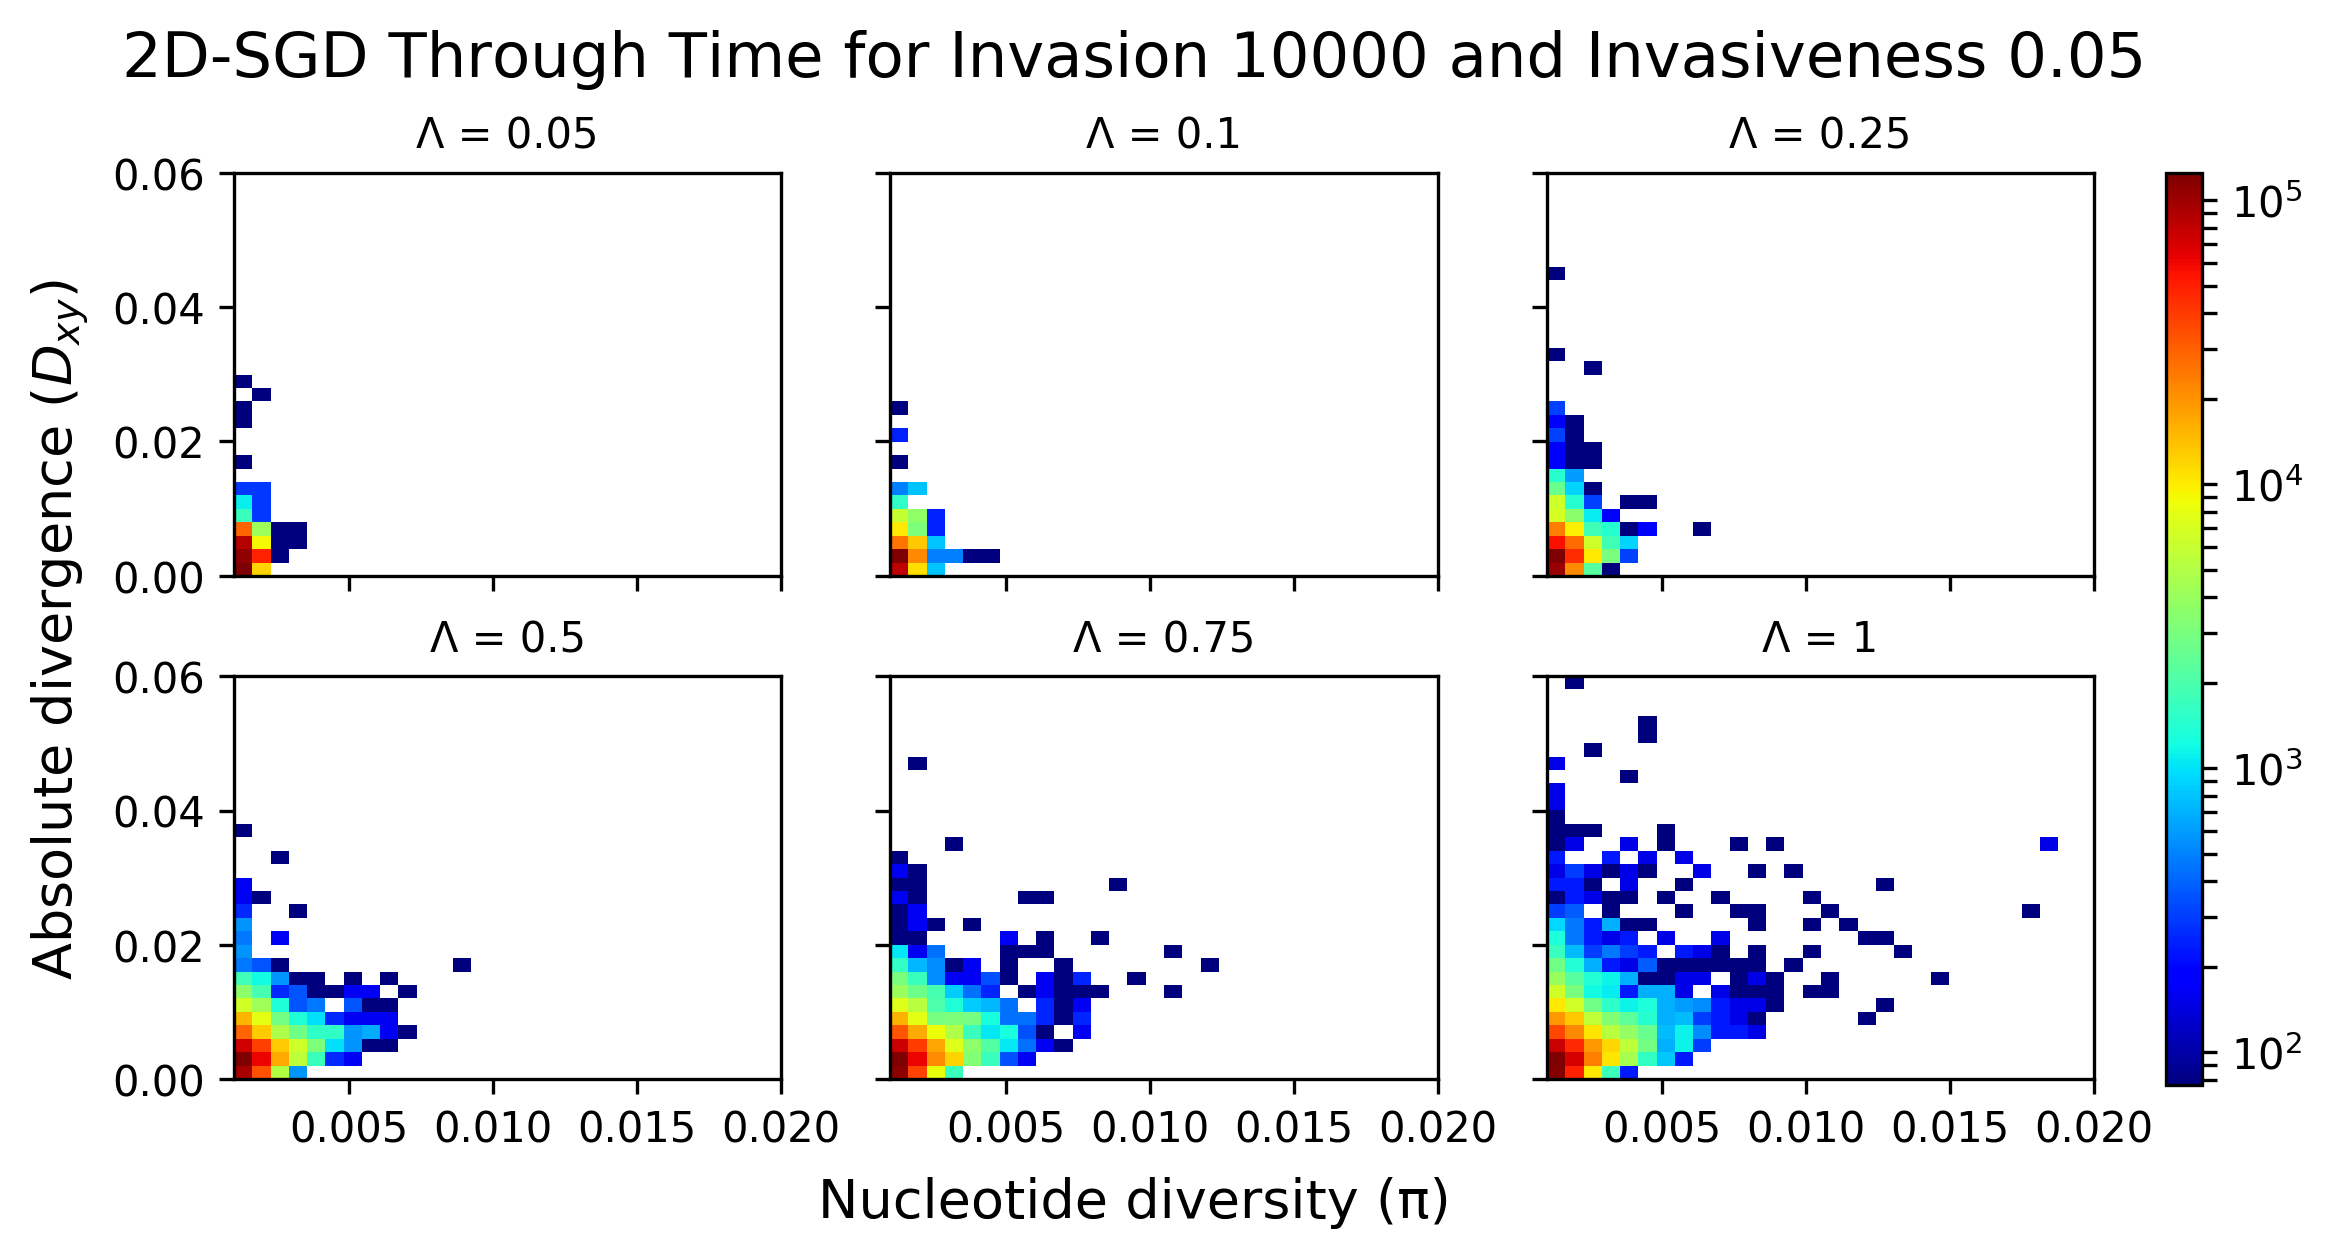

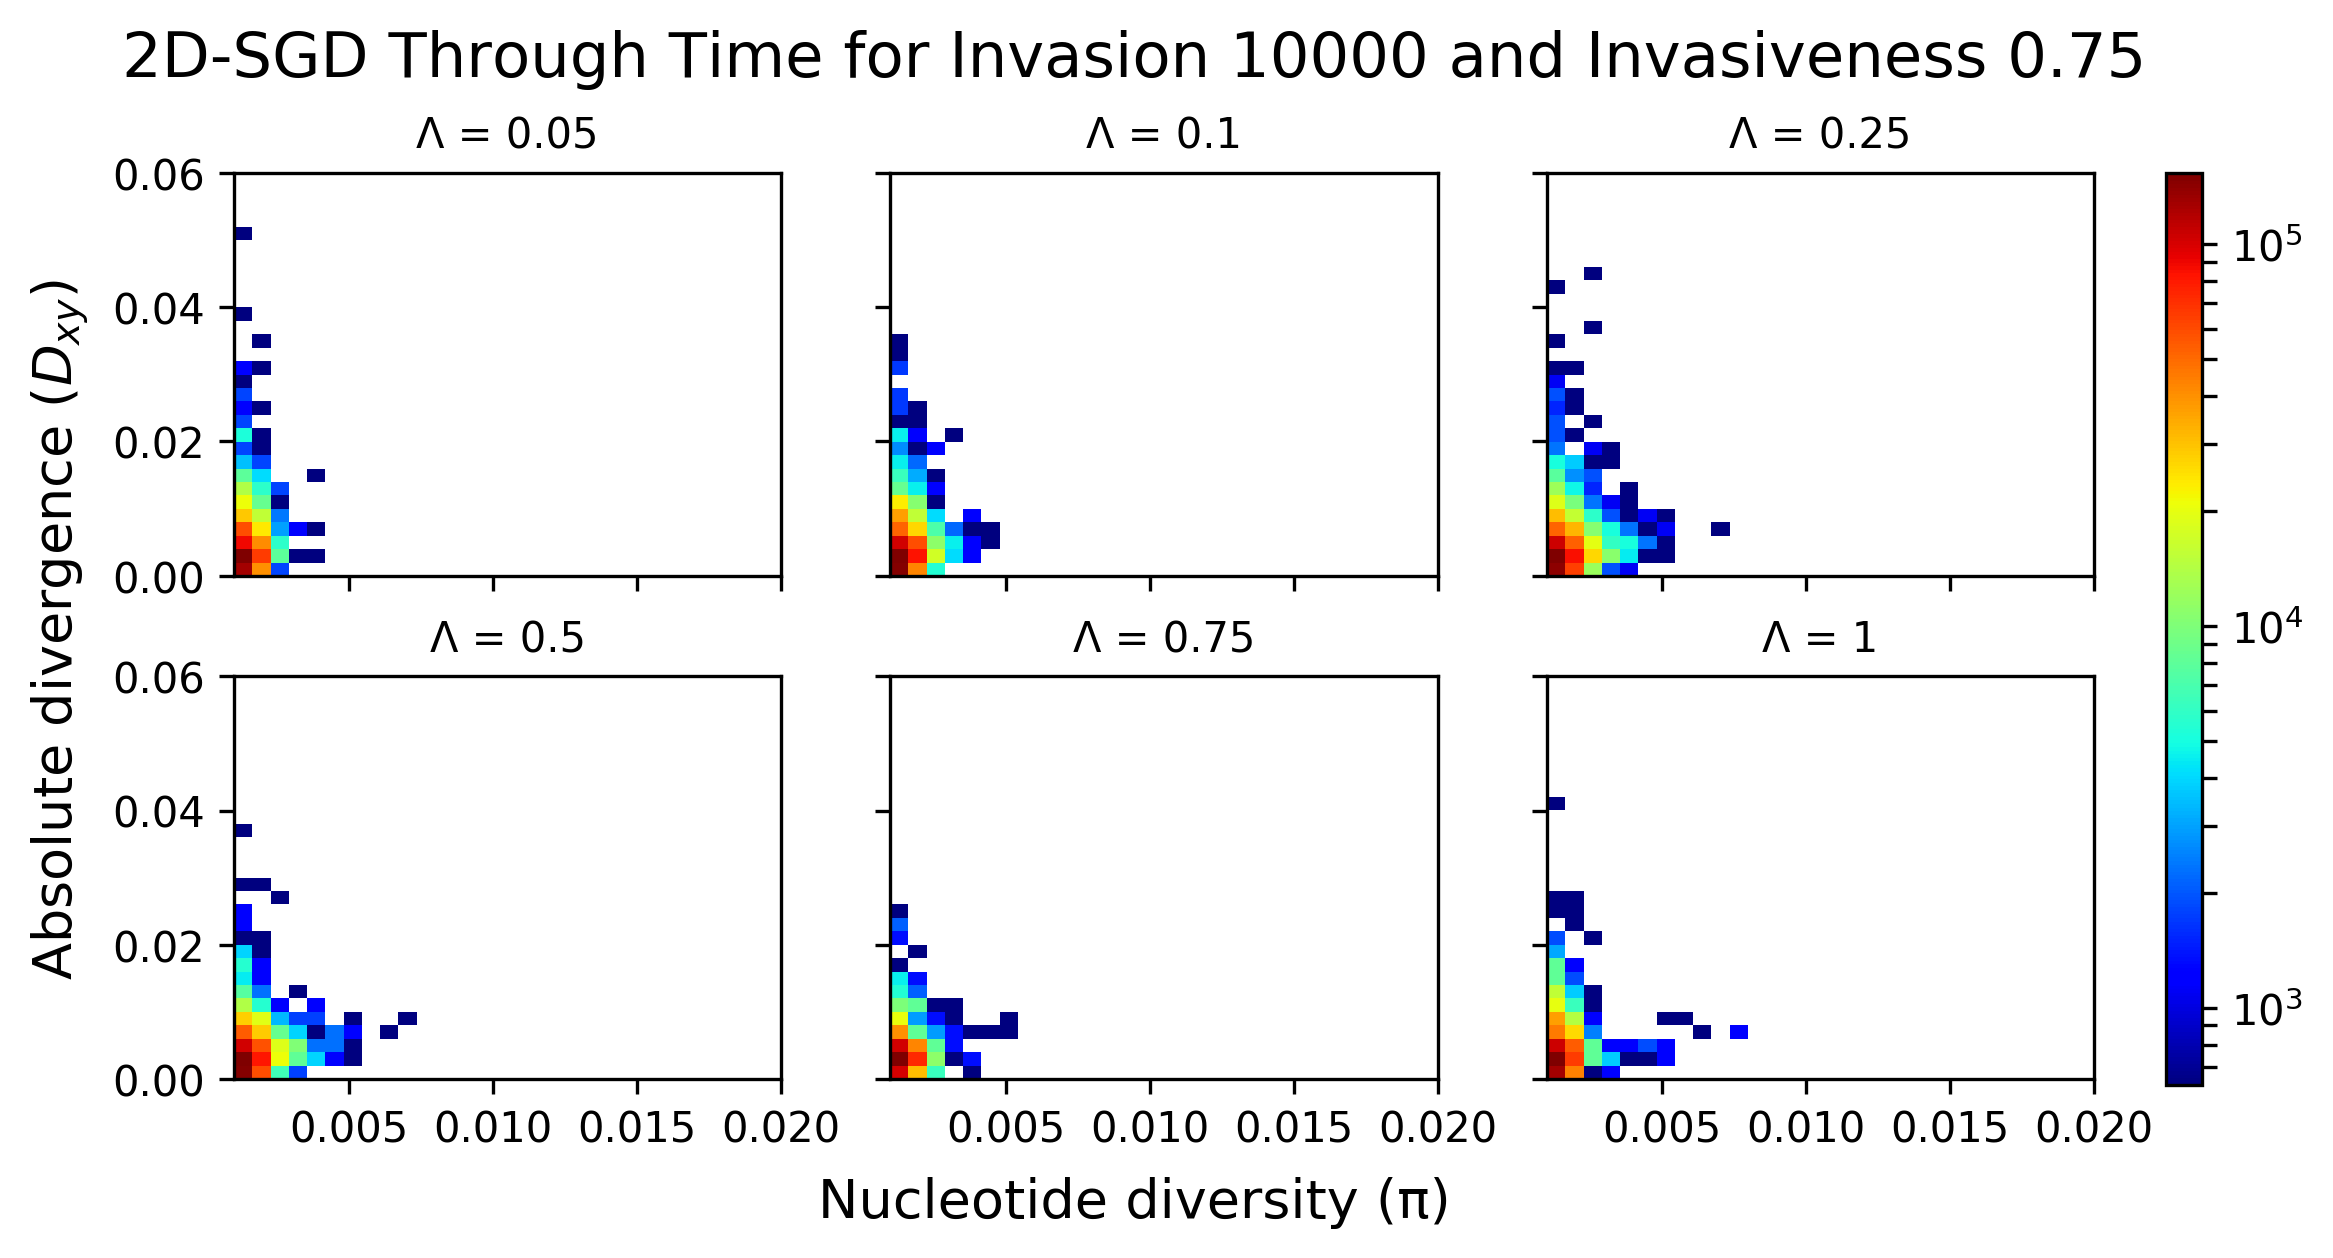

In [49]:
## Uncomment these and comment the below 2 for testing
for i in [10000]:
    for j in [0.05, 0.75]:
#for i in invasion_times:
#    for j in invasiveness_levels:
        plot_2dSGD_per_lambda(pi_dxy_dat[i][j]["pi"], pi_dxy_dat[i][j]["dxy"], i, j)

In [ ]:
def plot_per_invasiontime(data):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
    axarr = [a for b in axarr for a in b]


    for k, ax in zip(invasion_times, axarr):
        ax.set_title(u"Λ = {}".format(k))
        coltimes = lambda_dists[k]
        ax.hist(coltimes)
        ax.set_ylabel('N Species', color='b')
        ax.set_xlabel('Colonization Time', color='b')
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ## Super annoying
        #ax.get_xaxis().set_ticks(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5)))
        #ax.set_xticklabels(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/6)))#, fontsize=7)
        data = sorted(coltimes)
        loc, sc = expon.fit(data, floc=0)
        print("{} {}".format(k, sc))
        rv = expon(scale=sc)
        x = np.linspace(0, max(data), 100)

        ax1 = ax.twinx()
        ax1.plot(x, rv.pdf(x), color='black')
        ax1.get_yaxis().set_ticks([])
    plt.tight_layout()